### Ultimate Technologies Inc. Take-Home Challenge

#### Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
%matplotlib inline
import  warnings
warnings.simplefilter('ignore')

import datetime
import math

import json
from pandas.io.json import json_normalize
from matplotlib.lines import Line2D
import json
import datetime as dt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier

In [4]:
df_logins = pd.read_json('logins.json')

In [7]:
df_logins .shape

(93142, 1)

In [8]:
df_logins .head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
df_logins .tail(2)

,login_time
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [10]:
df_logins.isna().sum()

login_time    0
dtype: int64

Maximum and Minimum Date

In [98]:
print("min time: {}".format(df_logins.login_time.min()))
print("max time: {}".format(df_logins.login_time.max()))

min time: 1970-01-01 20:00:00
max time: 1970-04-13 18:45:00


In [12]:
df_logins.dtypes

login_time    datetime64[ns]
dtype: object

In [13]:
#Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex for using resample(), NOT RangeIndex
df_logins = df_logins.set_index('login_time')

In [14]:
# aggregate login counts based on 15-minute time intervals
df_logins['login_count'] = 0
df_logins = df_logins.resample('15min').count()
df_logins.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


#### Seasonal Decompose with Time Series

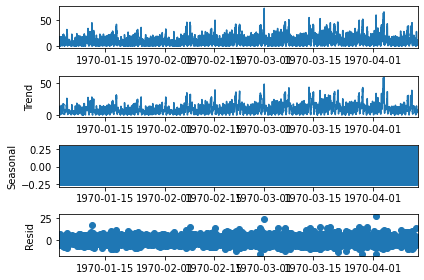

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

result_trend = sm.tsa.seasonal_decompose(df_logins, model='additive', period=4)
result_trend.plot();

In [16]:
df_logins = df_logins.reset_index()

#### Weekly Data Exploration

In [17]:
df_logins['weekday']=df_logins['login_time'].dt.day_name() #weekday = dayofweek (alias)
df_logins.head()

,login_time,login_count,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [18]:
# groupby('key', as_index=False): key does not become index but a column (no need reset_index() later)
login_dayweek = df_logins.groupby('weekday', as_index=False).sum()
login_dayweek

,weekday,login_count
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


#### Daily data Visualization

Text(0.5, 1.0, 'Logins by Day of Week')

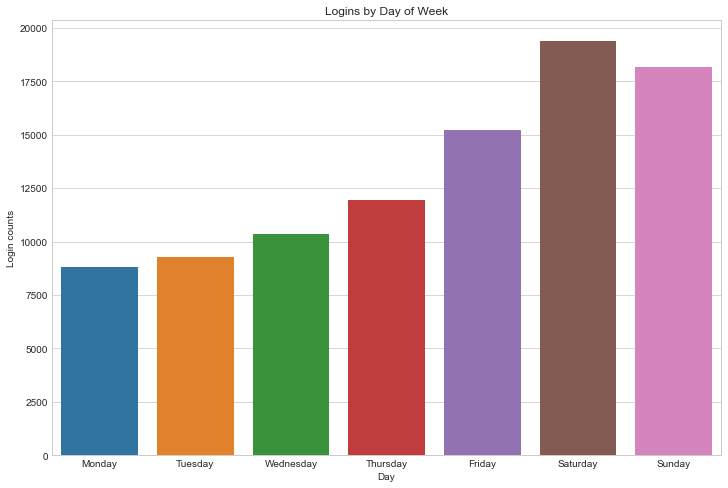

In [19]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(12,8)) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# bar plot
sns.barplot(x = 'weekday', y = 'login_count', data = login_dayweek, order=weekday_order)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of Week')

#### Observation:

Daily data shows Friday, Saturday, and Sunday are the best days.

In [20]:
df_logins['month'] = df_logins['login_time'].dt.month

In [21]:
df_logins['diff'] = df_logins.login_count.diff()

#### Monthly Data Visualization

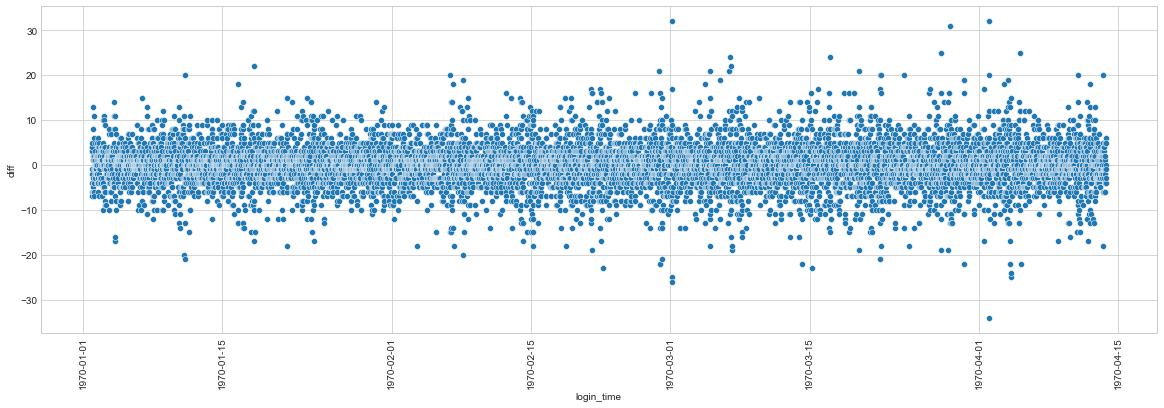

In [22]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=df_logins, x='login_time', y='diff')
plt.xticks(rotation=90)
plt.show()

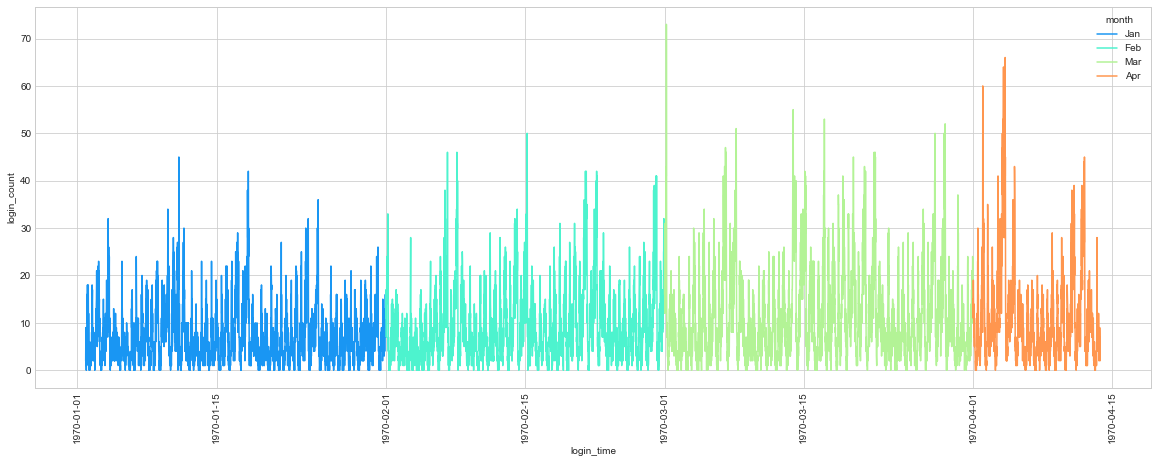

In [23]:
import matplotlib.dates as mdates
#extracting months
df_logins['month'] = df_logins['login_time'].dt.month
df_logins['month'] = df_logins["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr"})

#plotting df
# sns.scatterplot(data=df_logins, x='login_time', y='login_count')
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="login_time", y="login_count", data=df_logins, hue="month", palette="rainbow")
plt.xticks(rotation=90)
plt.show()

In [24]:
df_logins['month'] = df_logins["login_time"].dt.month 
df_mar = df_logins[df_logins.month == 3]

#### One month data visualization

Text(0, 0.5, 'Login count')

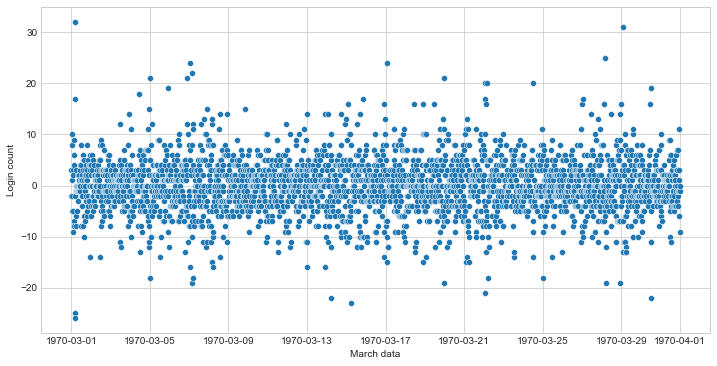

In [25]:
plt.figure(figsize=(12, 6))
mar = sns.scatterplot(data=df_mar, x='login_time', y='diff')
ax = mar.axes
plt.xlabel('March data')
plt.ylabel('Login count')

#### Hourly data exploration

In [26]:
df_logins['hour'] = df_logins['login_time'].dt.hour
df_logins.head(2)

,login_time,login_count,weekday,month,diff,hour
0,1970-01-01 20:00:00,2,Thursday,1,NaN,20
1,1970-01-01 20:15:00,6,Thursday,1,4.0,20


In [27]:
login_hour = df_logins.groupby('hour', as_index=False).sum()
login_hour.head(2)

,hour,login_count,month,diff
0,0,5993,924,5.0
1,1,6317,924,15.0


Text(0.5, 1.0, 'Logins by Hour')

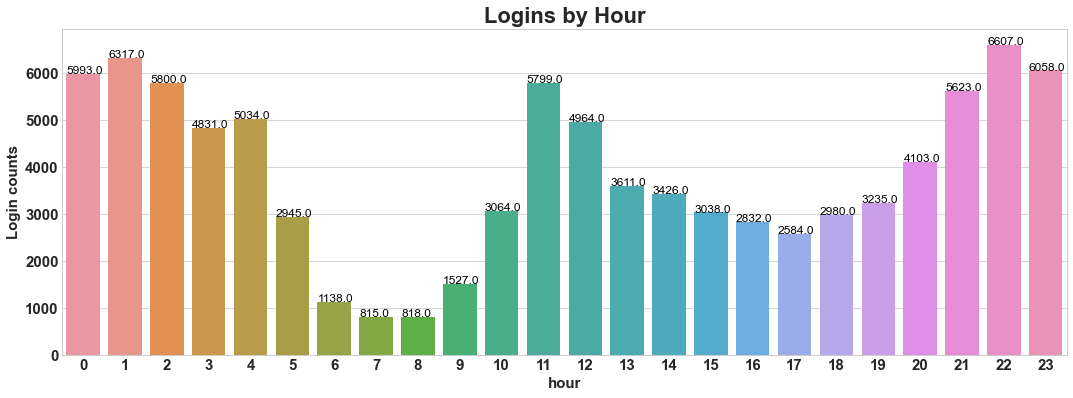

In [28]:
# number of transactions in each hour
plt.figure(figsize=(18,6))
ax = sns.barplot(x = 'hour', y = 'login_count', data = login_hour)
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
       
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)), fontsize=12, color='black')
    
plt.xlabel('hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('Login counts', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Logins by Hour', fontsize=22, fontweight='bold')

In [29]:
login_day_hour = df_logins.groupby(['weekday','hour'], as_index=False).sum()
login_day_hour.head(2)

,weekday,hour,login_count,month,diff
0,Friday,0,975,132,2.0
1,Friday,1,957,132,-30.0


<Figure size 2016x1008 with 0 Axes>

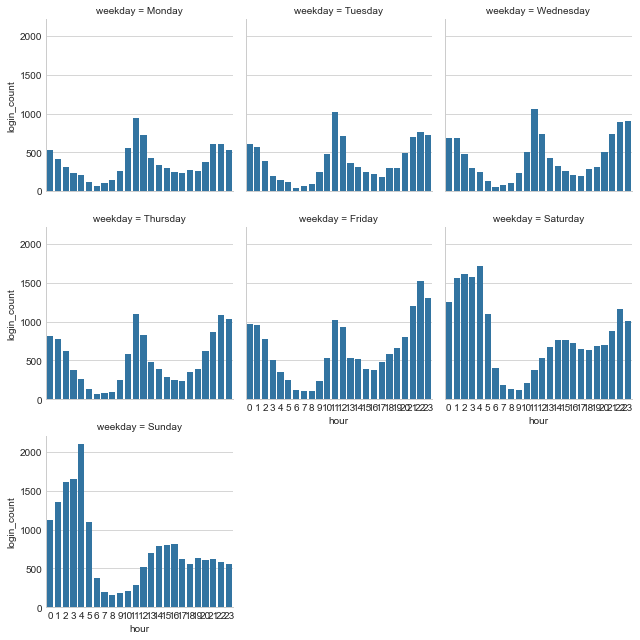

In [30]:
#Pandas - How to group-by and plot for each hour of each day of week
fig = plt.figure(figsize=(28,14))
g = sns.FacetGrid(login_day_hour, col="weekday", col_wrap=3, col_order=weekday_order)
g.map(sns.barplot, "hour", "login_count")

### DATA 2: EXPLORATORY DATA ANALYSIS

In [31]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
challenge = pd.DataFrame(data)
challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [32]:
challenge.shape

(50000, 12)

In [33]:
challenge.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [34]:
# Fill in the missing value with the mean values
# challenge['phone'].fillna(value='N/A', inplace=True)
challenge['phone'] = challenge['phone'].fillna(challenge['phone'].mode().iloc[0])
challenge['avg_rating_of_driver'].fillna(value=challenge['avg_rating_of_driver'].mean(), inplace=True)
challenge['avg_rating_by_driver'].fillna(value=challenge['avg_rating_by_driver'].mean(), inplace=True)

In [35]:
challenge.info

<bound method DataFrame.info of                  city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                  4.700000       1.10     2014-06-17   iPhone       15.4   
1                  5.000000       1.00     2014-05-05  Android        0.0   
2   

### Datetime Manipulation

In [36]:
challenge[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [37]:
challenge['last_trip_date'][0] # Right now they are strings

'2014-06-17'

In [38]:
#parse dates
challenge['signup_date'] = pd.to_datetime(challenge['signup_date'])
challenge['last_trip_date'] = pd.to_datetime(challenge['last_trip_date'])
challenge.head(1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0


### Labeling and Deriving Features

We first need to clarity an active user and a retention user.

A user is identified as an active user (active_user) if he/she takes a trip ("active") in the 6th month on the system.

For identifying the retention user (retention_user), we do need to know the date when the data was pulled. As instructed users are retained if they were “active” (i.e. took a trip) in the preceding 30 days (from the date when the data was pulled). But, we do not know the exact date, so we regard the maximum last_trip_date as the baseline.

As defined in the instruction, we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [39]:
# if the last trip was within last 30 days of the most recent trip then we will consider it to be retained
retain_window = max(challenge.last_trip_date) - dt.timedelta(days=30)
challenge['retained_users'] = challenge.apply(lambda x: 1 if x.last_trip_date > retain_window else 0, axis=1)

In [40]:
challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_users
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


### Finding Active and Inactive Data

In [41]:
active = challenge[challenge["retained_users"] > 0]
inactive = challenge[challenge["retained_users"] == 0]

print("Active:",  active.shape)
print("Inactive:",  inactive.shape)

Active: (18310, 13)
Inactive: (31690, 13)


### Visualizing the Active and Inactive data

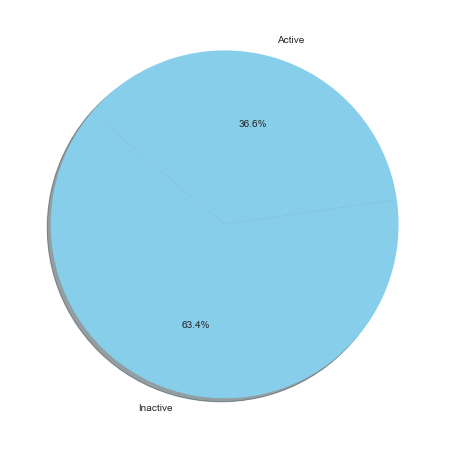

In [42]:
fig = plt.figure(figsize = (8,8))
colors = ["skyblue"]
inactive = challenge[challenge["retained_users"] == 0 ]
active = challenge[challenge["retained_users"] == 1 ]

count = [inactive['retained_users'].count(), active['retained_users'].count()]
pie = plt.pie(count, labels = ['Inactive', 'Active'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 140,
              )
plt.show()


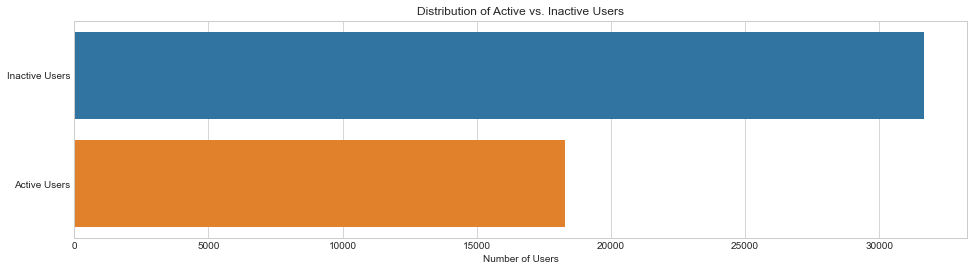

In [43]:
f, axes = plt.subplots(figsize=(16,4))
ax = sns.countplot(y=challenge["retained_users"])
ax.set(title="Distribution of Active vs. Inactive Users", \
       xlabel="Number of Users", ylabel="")
ax.set_yticklabels(["Inactive Users", "Active Users"])
plt.show()

In [44]:
bool_feature_mask = challenge.dtypes==np.bool
bool_cols = challenge.columns[bool_feature_mask].tolist()
bool_cols
def boolToint(x):
    if(x==True):
        return 1
    elif(x==False):
        return 0
    return "error"

for b in bool_cols:
    challenge[b] = challenge[b].apply(boolToint)

In [45]:
# Categorical boolean mask
categorical_feature_mask = challenge.dtypes==np.object
# filter categorical columns using mask and turn it into a list
categorical_cols = challenge.columns[categorical_feature_mask].tolist()
categorical_cols

['city', 'phone']

### Distribution of Features

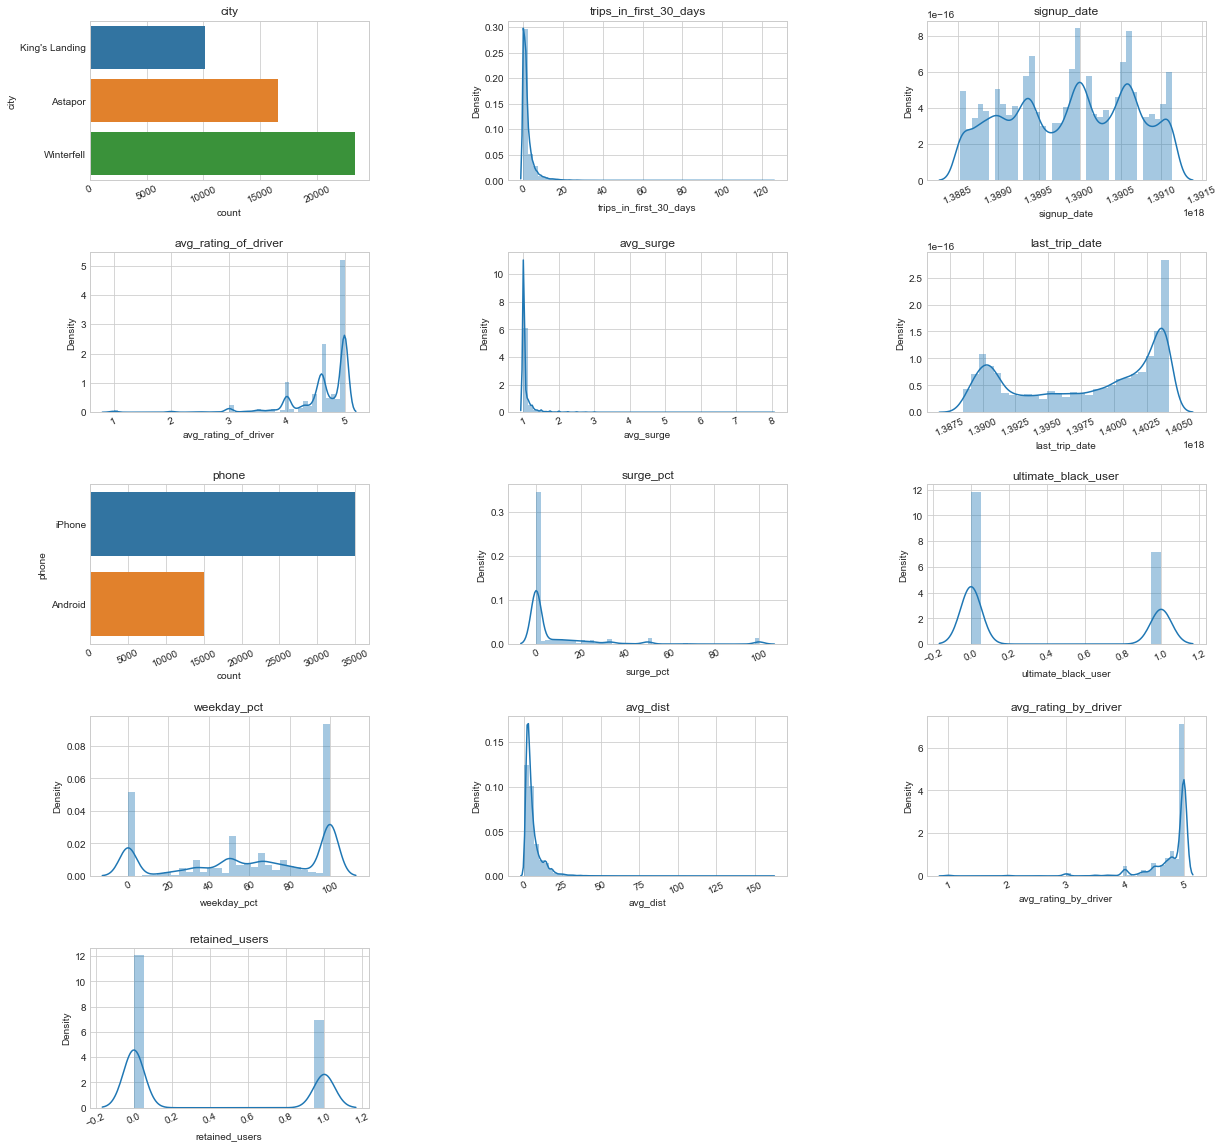

In [46]:
# Let’s plot the distribution of each feature for plot_distribution
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object: #Categorical
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else: #Numerical
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(challenge, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

In [47]:
# Table of ultimate balck vs active
ub_active = pd.crosstab(index=challenge["retained_users"], 
                            columns=challenge["ultimate_black_user"],
                             margins=True)   # Include row and column totals

ub_active.columns = ["Not Ultimate Black","Is Ultimate Black","rowtotal"]
ub_active.index= ["Not Active","Is Active","coltotal"]

ub_active

,Not Ultimate Black,Is Ultimate Black,rowtotal
Not Active,22195,9495,31690
Is Active,8951,9359,18310
coltotal,31146,18854,50000


In [48]:
# Table of ultimate black vs active
ub_active = pd.crosstab(index=challenge["retained_users"], 
                            columns=challenge["ultimate_black_user"],
                             margins=True)   # Include row and column totals

ub_active.columns = ["Not Ultimate Black","Is Ultimate Black","rowtotal"]
ub_active.index= ["Not Active","Is Active","coltotal"]

ub_active

,Not Ultimate Black,Is Ultimate Black,rowtotal
Not Active,22195,9495,31690
Is Active,8951,9359,18310
coltotal,31146,18854,50000


In [49]:
# Table of phone type vs active
phone_active = pd.crosstab(index=challenge["retained_users"], 
                            columns=challenge["phone"],
                             margins=True)   # Include row and column totals

phone_active.columns = ["Android","iPhone","rowtotal"]
phone_active.index= ["Not Active","Is Active","coltotal"]

phone_active

,Android,iPhone,rowtotal
Not Active,12080,19610,31690
Is Active,2942,15368,18310
coltotal,15022,34978,50000


In [50]:
# Table of ultimate balck vs active
city_active = pd.crosstab(index=challenge["retained_users"], 
                            columns=challenge["city"],
                             margins=True)   # Include row and column totals

city_active.columns = ["Astapor","King's Landing",'Winterfell',"rowtotal"]
city_active.index= ["Not Active","Is Active","coltotal"]

city_active

,Astapor,King's Landing,Winterfell,rowtotal
Not Active,12512,3823,15355,31690
Is Active,4022,6307,7981,18310
coltotal,16534,10130,23336,50000


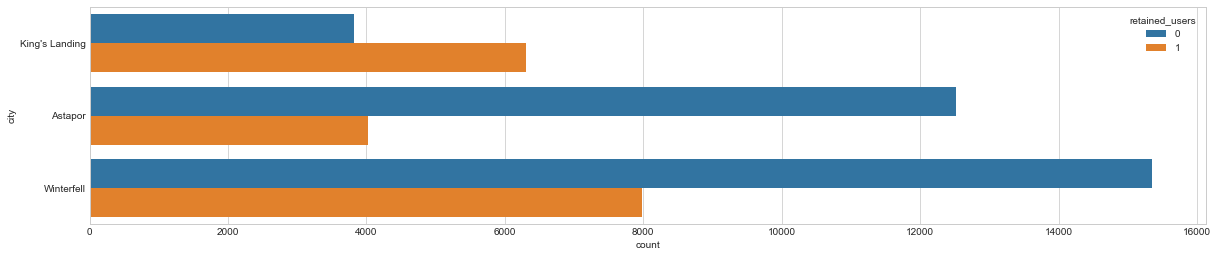

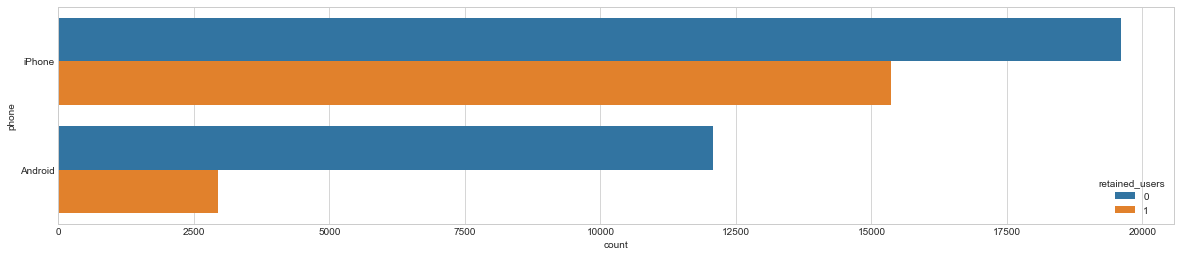

In [51]:
# categorical bi-variate analysis
plt.style.use('seaborn-whitegrid')

for cat in categorical_cols:
    fig = plt.figure(figsize=(20,4)) 
    sns.countplot(y=cat, hue="retained_users", data=challenge)

<AxesSubplot:xlabel='phone', ylabel='ultimate_black_user'>

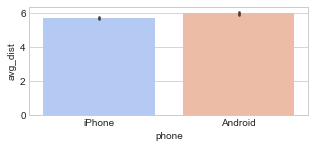

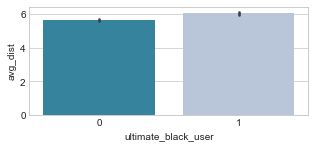

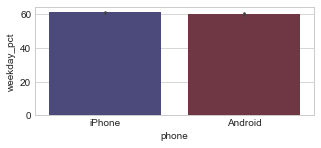

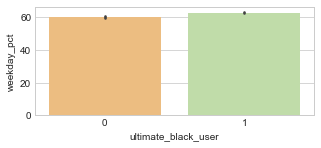

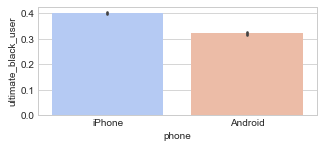

In [53]:
# two variables
fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='avg_dist', data=challenge, palette="coolwarm")

fig = plt.figure(figsize=(5,2)) 
sns.barplot(y='avg_dist', x='ultimate_black_user', data=challenge, palette='PuBuGn_r')

fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='weekday_pct', data=challenge, palette="icefire")

fig = plt.figure(figsize=(5,2)) 
sns.barplot(y='weekday_pct', x='ultimate_black_user', data=challenge, palette="Spectral")

fig = plt.figure(figsize=(5,2)) 
sns.barplot(x='phone', y='ultimate_black_user', data=challenge, palette="coolwarm")

In [54]:
# drop time columns
time_cols = ['last_trip_date', 'signup_date']
challenge = challenge.drop(time_cols, axis=1)

In [55]:
challenge.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_users
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0


### PREDICTIVE MODELING

In [56]:
### Train-Test Split
len(challenge) * .7, len(challenge) * .3

(35000.0, 15000.0)

In [57]:
X = challenge.drop('retained_users', axis=1)
y = challenge['retained_users']

Dummies

The drop_first=True drops one column from the resulted dummy features. The purpose is to avoid multicollinearity.

In [58]:
# Pandas get_dummies 
X_encoded_getdummies = pd.get_dummies(X, columns = categorical_cols, prefix_sep='_', drop_first=True) 

In [59]:
X_encoded_getdummies.head(2)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.1,15.4,1,46.2,3.67,5.0,1,0,1
1,0,5.0,1.0,0.0,0,50.0,8.26,5.0,0,0,0


In [60]:
X = X_encoded_getdummies
y = challenge['retained_users']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

### Model 1: Logistic Regression

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### Fit the Model and Predict 

In [63]:
# Create the classifier: logreg
logreg = LogisticRegression(solver='liblinear')

# Fit the classifier to the training data
logreg = logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8173 1334]
 [2750 2743]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      9507
           1       0.67      0.50      0.57      5493

    accuracy                           0.73     15000
   macro avg       0.71      0.68      0.69     15000
weighted avg       0.72      0.73      0.72     15000



### Confusion Matrix

In [64]:
TP, FP, FN, TN = confusion_matrix(y_test, y_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Active': [TP, FP],
                                 'Predicted = Inactive': [FN, TN]
                                }, index=['Active', 'Inactive'])
c_matrix

,Predicted = Active,Predicted = Inactive
Active,8173,2750
Inactive,1334,2743


### ROC-AUC Curve

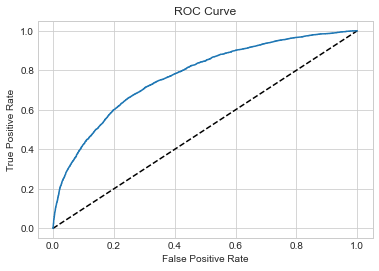

In [65]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [66]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("Logistic regression ROC-AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Logistic regression ROC-AUC: 0.773001452971376


### Hyperparameter Tuning

In [67]:
# Setup the hyperparameter grid
Cs = np.logspace(0.01, 0.5, 1, 5)
param_grid = {'C': Cs}
# Instantiate a logistic regression classifier: logreg
logreg_tuned = LogisticRegression(solver='liblinear')

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg_tuned, param_grid, cv=5)

#Fit the model on the train set
logreg_model = logreg_cv.fit(X_train, y_train)

# Prediction on the test set
prediction = logreg_model.predict(X_test)
# Print the tuned parameters and score
print("regularized Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

regularized Logistic Regression Parameters: {'C': 1.023292992280754}
Best score is 0.7224571428571428


### Logistic Regression Scores

In [68]:
print(f"recall_score:  {recall_score(y_test, prediction)* 100}")
print(f"precision_score:  {precision_score(y_test, prediction)* 100}")
print(f"F1 score:  {f1_score(y_test, prediction, average='weighted')* 100}")
print(f"accuracy_score:  {accuracy_score(y_test, prediction)* 100}")
print("Logistic regression ROC-AUC: {}".format(roc_auc_score(y_test, prediction)* 100))

recall_score:  49.93628254141635
precision_score:  67.27986264410106
F1 score:  71.70261003472366
accuracy_score:  72.77333333333334
Logistic regression ROC-AUC: 67.95225823715396


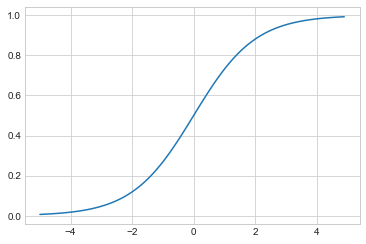

In [69]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=1);


### Model 2: RandomForestClassifier

### Fit the Model and Predict

In [70]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state = 47,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

### Confusion Matrix

In [71]:
TP, FP, FN, TN = confusion_matrix(y_test, y_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Active': [TP, FP],
                                 'Predicted = Inactive': [FN, TN]
                                }, index=['Active', 'Inactive'])
c_matrix

,Predicted = Active,Predicted = Inactive
Active,7787,1814
Inactive,1720,3679


In [72]:
# Scores

print(f"recall_score:  {recall_score(y_test, y_pred)* 100}")
print(f"precision_score:  {precision_score(y_test, y_pred)* 100}")
print(f"F1 score:  {f1_score(y_test, y_pred, average='weighted')* 100}")
print(f"accuracy_score:  {accuracy_score(y_test, y_pred)* 100}")
print("ROC-AUC: {}".format(roc_auc_score(y_test, y_pred)* 100))

recall_score:  66.97615146550154
precision_score:  68.14224856454899
F1 score:  76.39628699029218
accuracy_score:  76.44
ROC-AUC: 74.44210960253092


### ROC-AUC Curve

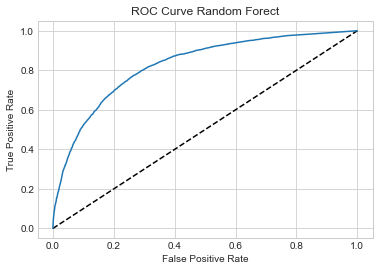

In [73]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_RF = model_res.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_RF)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forect')
plt.show()

### Model 3: XG Boost Classifier

In [74]:
import xgboost
from xgboost import XGBClassifier

### Fit the Model and Predict

In [75]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

[17:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1, 0.3], 
             'subsample': [0.6, 1]}          


# specify model
xgb_model = XGBClassifier(max_depth=6, n_estimators=100)

# set up GridSearchCV()
XgB_model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
XgB_model_cv.fit(X_train, y_train)  


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[17:27:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:40]

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=6, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=No

In [77]:
XgB_model_cv.best_params_

{'learning_rate': 0.1, 'subsample': 1}

In [78]:
# Applying the hyperparameters

params = {'learning_rate': 0.1,
          'max_depth': 6, 
          'n_estimators':100,
          'subsample':1,
         'objective':'binary:logistic'}

# fit model on training data
XgB_df_model = XGBClassifier(params = params)
XgB_df_model.fit(X_train, y_train)

[17:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:28:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1,
              params={'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100,
                      'objective': 'binary:logistic', 'subsample': 1},
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [79]:
# Predictions on the test set
XgB_test_pred = XgB_df_model.predict(X_test)

### Confusion Matrix

In [80]:
TP, FP, FN, TN = confusion_matrix(y_test, XgB_test_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Active': [TP, FP],
                                 'Predicted = Inactive': [FN, TN]
                                }, index=['Active', 'Inactive'])
c_matrix

,Predicted = Active,Predicted = Inactive
Active,9040,1994
Inactive,1456,4010


### ROC-AUC Curve

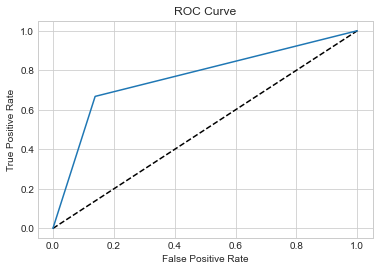

In [81]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob2 = XgB_df_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, XgB_test_pred)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [82]:
# Scores:

print(f"recall_score:  {recall_score(y_test, XgB_test_pred)* 100}")
print(f"precision_score:  {precision_score(y_test, XgB_test_pred)* 100}")
print(f"F1 score:  {f1_score(y_test, XgB_test_pred, average='weighted')* 100}")
print(f"accuracy_score:  {accuracy_score(y_test, XgB_test_pred)* 100}")
print("ROC-AUC: {}".format(roc_auc_score(y_test, XgB_test_pred)* 100))

recall_score:  66.7888074616922
precision_score:  73.36260519575558
F1 score:  78.86178119664777
accuracy_score:  79.0909090909091
ROC-AUC: 76.45842812109001


### Feature Importance

Text(0, 0.5, 'Feature Importance Score')

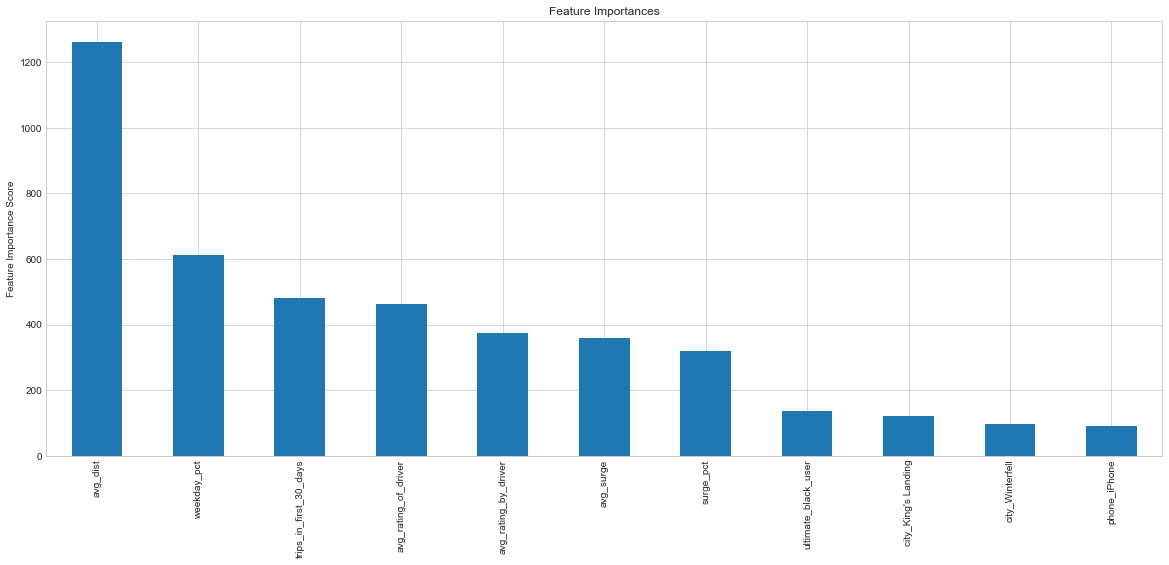

In [83]:
plt.figure(figsize=(20,8))
feat_imp = pd.Series(XgB_df_model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Model 4: Decision Tree

In [84]:
entropy_model = DecisionTreeClassifier()

### Fit the Model and Predict

In [85]:
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier

entropy_model = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=6, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

entropy_model.fit(X_train, y_train)
entropy_pred = entropy_model.predict(X_test)
entropy_pred = pd.Series(entropy_pred)
entropy_model

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=50,
                       min_samples_split=50, random_state=100)

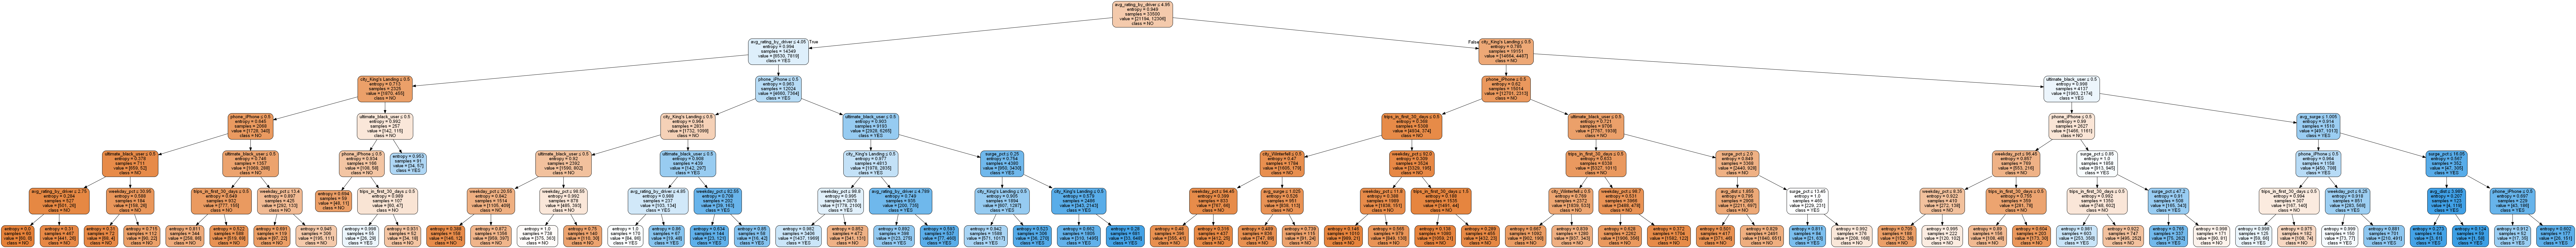

In [86]:
from io import StringIO 
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
tree.export_graphviz(entropy_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns, class_names = ["NO", "YES"])


# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Confusion Matrix

In [87]:
TP, FP, FN, TN = confusion_matrix(y_test, entropy_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Active': [TP, FP],
                                 'Predicted = Inactive': [FN, TN]
                                }, index=['Active', 'Inactive'])
c_matrix

,Predicted = Active,Predicted = Inactive
Active,8677,2062
Inactive,1819,3942


In [88]:
# Scores:

print(f"recall_score:  {recall_score(y_test, entropy_pred)* 100}")
print(f"precision_score:  {precision_score(y_test, entropy_pred)* 100}")
print(f"F1 score:  {f1_score(y_test, entropy_pred, average='weighted')* 100}")
print(f"accuracy_score:  {accuracy_score(y_test, entropy_pred)* 100}")
print("ROC-AUC: {}".format(roc_auc_score(y_test, entropy_pred)* 100))

recall_score:  65.6562291805463
precision_score:  68.42562055198749
F1 score:  76.37045962098622
accuracy_score:  76.47878787878788
ROC-AUC: 74.1629087975902


### ROC-AUC Score

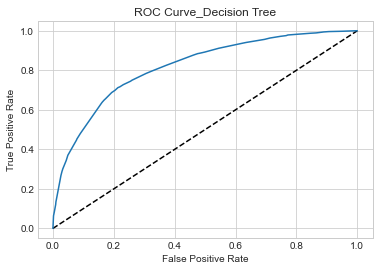

In [89]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob_DT = entropy_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_DT)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve_Decision Tree')
plt.show()

### MODEL COMPARISIONS

###  F1 Score Comparision of the Models

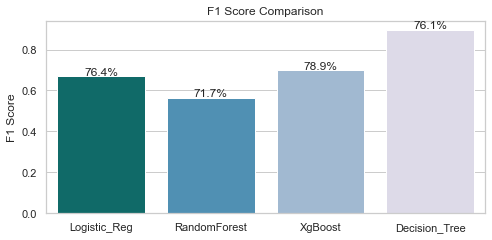

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
percentage = [76.37, 71.70, 78.86, 76.09]
ax = sns.barplot(x= ["Logistic_Reg","RandomForest","XgBoost","Decision_Tree"],
                 y= [f1_score(entropy_model.predict(X_test), y_test), f1_score(logreg_model.predict(X_test), y_test),
               f1_score(XgB_df_model.predict(X_test), y_test), f1_score(model_res.predict(X_test), y_test)], palette='PuBuGn_r')
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+0.005
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score") 
plt.show()

#### Observation:

Decision tree model and XgBoost work very well for the given dataset.

### ROC-AUC Score Comparision of the Models

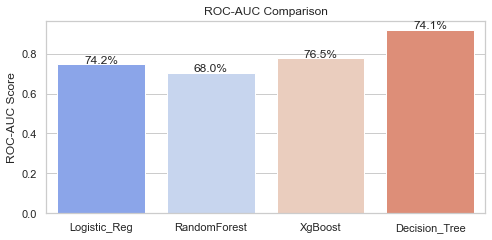

In [96]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
percentage = [74.16, 67.95, 76.45, 74.09]
ax = sns.barplot(x= ["Logistic_Reg","RandomForest","XgBoost","Decision_Tree"],
                 y= [roc_auc_score(entropy_model.predict(X_test), y_test), roc_auc_score(logreg_model.predict(X_test), y_test),
               roc_auc_score(XgB_df_model.predict(X_test), y_test), roc_auc_score(model_res.predict(X_test), y_test)], palette='coolwarm')
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+0.005
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.title("ROC-AUC Comparison")
plt.ylabel("ROC-AUC Score") 
plt.show()

#### Observation:

Here also, XgBoost and Decision Tree Model work very well.

### Accuracy Score Comparision of the Models

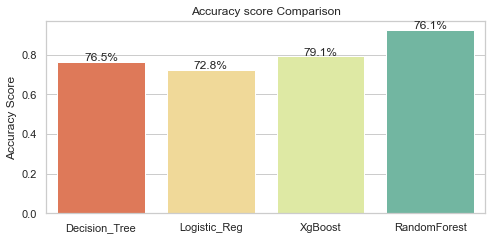

In [97]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
percentage = [76.47, 72.77, 79.07, 76.12]
ax = sns.barplot(x= ["Decision_Tree", "Logistic_Reg", "XgBoost", "RandomForest"],
                 y= [accuracy_score(entropy_model.predict(X_test), y_test), accuracy_score(logreg_model.predict(X_test), y_test),
               accuracy_score(XgB_df_model.predict(X_test), y_test), accuracy_score(model_res.predict(X_test), y_test)], palette="Spectral")
patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+0.005
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.title("Accuracy score Comparison")
plt.ylabel("Accuracy Score") 
plt.show()


#### Observation:


In this case also, XgBoost and Decision Tree Model are working very well.

### Conclusion

The approach was to determine the number of active users. Identify which continuous (numerical) data was correlated to activity, identify which categorical data was correlated to activity, and then build a model to predict active users. The model F1 score in approximately 78%, Accuracy of 79%, ROC of 76% of its predictions.

For the model, I initially used logistic regression as it is a solid predictor of binary classification. Users who use the service for local, smaller trips are most likely to engage frequently and remain active. A comparison to King's Landing would be beneficial as those users are very active. It also seems that there is a better app experience for iPhone users.

Reference: Towards Data Science, Analytics Vidhya, Machine Learning Mastery, Github, Stackoverflow